In [2]:
import os
import sys

# Добавляем корневую директорию проекта в sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))

# Импортируем metrics из utils
from utils import metrics as mtc

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Готовим дата-сеты с регионом

In [4]:
reference = pd.read_csv("../../data/reference.csv")
train = pd.read_csv("../../data/splited/train.csv")
valid = pd.read_csv("../../data/splited/valid.csv")
test = pd.read_csv("../../data/splited/test.csv")

In [5]:
reference.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      305 non-null    int64 
 1   name    305 non-null    object
 2   region  305 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.3+ KB


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551 entries, 0 to 550
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       551 non-null    object
 1   school_id  551 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.7+ KB


In [7]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       184 non-null    object
 1   school_id  184 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ KB


In [8]:
reference.head()

,id,name,region
0,69,Кировска,Мурманская область
1,70,Клин спортивный,Московская область
2,71,КО СШ по ЗВС,Калининградская область
3,8,Айсберг,Свердловская область
4,73,Команда Дмитриева,Челябинская область


In [9]:
reference.region = reference.region.str.lower().str.strip()

In [10]:
reference.region = reference.region.str.replace("г ", "")
reference.region = reference.region.str.replace("г. ", "")
reference.region = reference.region.str.replace("г.", "")
reference.region = reference.region.str.replace(
    "хмао-югра", "ханты мансийский автономный округ"
)
reference.region = reference.region.str.replace("спб", "санкт петербург")
reference.region = reference.region.str.replace(
    "ямало-ненецкий ао", "ямало ненецкий автономный округ"
)
reference.region = reference.region.str.replace(
    "республика чувашия", "чувашская республика"
)
reference.region = reference.region.str.replace("северодвинск", "архангельская область")
reference.region = reference.region.str.replace(
    "набережные челны", "республика татарстан"
)
reference.region = reference.region.str.replace("санкт-петербург", "санкт петербург")

In [11]:
reference.region.sort_values().unique()

array(['алтайский край', 'архангельская область', 'астраханская область',
       'белгородская область', 'брянская область', 'владимирская область',
       'волгоградская область', 'вологодская область',
       'воронежская область', 'забайкальский край', 'ивановская область',
       'иркутская область', 'калининградская область',
       'калужская область', 'кемеровская область', 'кировская область',
       'костромская область', 'краснодарский край', 'красноярский край',
       'курганская область', 'курская область', 'ленинградская область',
       'липецкая область', 'москва', 'московская область',
       'мурманская область', 'нижегородская область',
       'новгородская область', 'новосибирская область', 'омская область',
       'оренбургская область', 'орловская область', 'пензенская область',
       'пермский край', 'приморский край', 'псковская область',
       'республика башкортостан', 'республика карелия', 'республика коми',
       'республика крым', 'республика марий эл', 

In [12]:
valid = pd.read_csv("../../data/preprocessed/cosine_region/valid_region.csv", sep=";")

In [13]:
valid.head()

,name,school_id,region
0,сшор,198,санкт петербург
1,мауо до сш 11,184,липецкая область
2,ано лига фигурного катания,293,москва
3,кфк динамо,277,санкт петербург
4,мбау всшор,35,ленинградская область


### Преобразования в np.array

In [14]:
x = valid["name"].to_numpy(dtype="str").flatten()
y = valid["school_id"].to_numpy(dtype="int").flatten()
region = valid["region"].to_numpy(dtype="str").flatten()
reference_id = reference["id"].to_numpy(dtype="int").flatten()
reference_name = reference["name"].to_numpy(dtype="str").flatten()
reference_region = reference["region"].to_numpy(dtype="str").flatten()

# Построение модели

In [15]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances


def calculate_similarity(x, y, method="cosine"):
    if method == "cosine":
        return cosine_similarity(x, y)
    elif method == "euclidean":
        return -euclidean_distances(x, y)  # Инвертируем, чтобы максимизировать схожесть
    elif method == "manhattan":
        return -manhattan_distances(x, y)  # Инвертируем, чтобы максимизировать схожесть
    else:
        raise ValueError(f"Unknown similarity method: {method}")

In [16]:
def find_matches(
    x_vec,
    x_region,
    reference_id,
    reference_vec,
    reference_region,
    top_k=5,
    threshold=0.9,
    filter_by_region=True,
    empty_region="all",
    similarity_method="cosine",
):
    y_pred = []
    manual_review = []

    for i, x in enumerate(x_vec):
        # Фильтруем reference_vec и reference_id по текущему региону, если включена фильтрация по регионам
        if filter_by_region:
            # Фильтруем reference_vec и reference_id по текущему региону
            current_region = x_region[i]
            region_mask = reference_region == current_region
            filtered_reference_vec = reference_vec[region_mask]
            filtered_reference_id = reference_id[region_mask]

            # Способ обработки, если в текущем регионе нет школ для сравнения
            if empty_region == "all":
                # Если в текущем регионе нет школ для сравнения, используем все школы
                if filtered_reference_vec.shape[0] == 0:
                    filtered_reference_vec = reference_vec
                    filtered_reference_id = reference_id
            else:
                if filtered_reference_vec.shape[0] == 0:
                    # Если в текущем регионе нет школ для сравнения, то помечаем на ручную обработку
                    manual_review.append(x)
                    top_matches = [(None, 0.0)] * top_k
                    y_pred.append(top_matches)
                    continue
        else:
            filtered_reference_vec = reference_vec
            filtered_reference_id = reference_id

        # Вычисляем выбранное расстояние
        similarities = calculate_similarity(
            x, filtered_reference_vec, method=similarity_method
        ).flatten()
        top_indices = similarities.argsort()[-top_k:][::-1]
        max_similarity = max(similarities)

        # Учитываем пороговое значение для различных методов
        if similarity_method == "cosine":
            if max_similarity < threshold:
                manual_review.append(x)
                top_matches = [(None, 0.0)] * top_k
            else:
                top_matches = [
                    (filtered_reference_id[i], similarities[i]) for i in top_indices
                ]
                if len(top_matches) < top_k:
                    top_matches += [(None, 0.0)] * (top_k - len(top_matches))
        else:  # Для других методов расстояний (евклидово и манхэттенское)
            if max_similarity > -threshold:  # Обратите внимание на инверсию
                manual_review.append(x)
                top_matches = [(None, 0.0)] * top_k
            else:
                top_matches = [
                    (filtered_reference_id[i], -similarities[i]) for i in top_indices
                ]
                if len(top_matches) < top_k:
                    top_matches += [(None, 0.0)] * (top_k - len(top_matches))

        y_pred.append(top_matches)

    return y_pred, manual_review

# Использование модели

In [17]:
# Векторизация текстов
vectorizer = TfidfVectorizer().fit(np.append(x, reference_name))
x_vec = vectorizer.transform(x)
reference_vec = vectorizer.transform(reference_name)

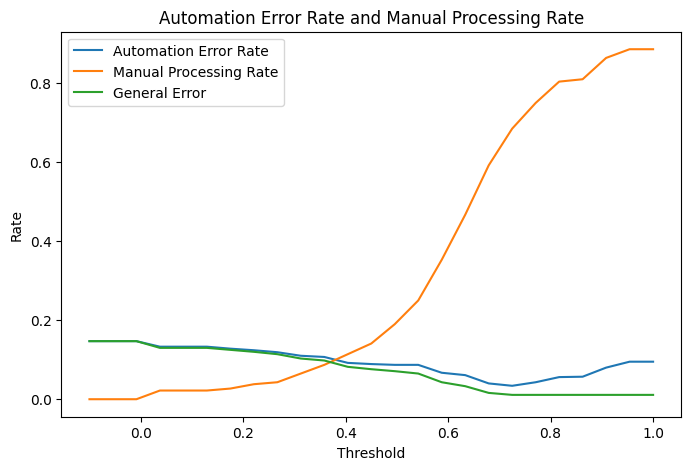

In [33]:
# Массив значений threshold
threshold_values = np.linspace(-0.1, 1.0, 25)

# Запуск функции и сбор метрик
metrics_list = []
for threshold in threshold_values:
    y_pred, manual_review = find_matches(
        x_vec,
        region,
        reference_id,
        reference_vec,
        reference_region,
        top_k=5,
        threshold=threshold,
        filter_by_region=True,
        empty_region="all",
        # similarity_method="euclidean",
        similarity_method="cosine",
        # similarity_method="manhattan",
    )
    metrics = mtc.calculate_metrics(y, y_pred, manual_review)
    metrics_list.append(metrics)

# Преобразование метрик в удобный формат для построения графика
auto_error_rate_values = [metrics["auto_error_rate"] for metrics in metrics_list]
manual_processing_rate_values = [
    metrics["manual_processing_rate"] for metrics in metrics_list
]
# general_spend_values = [metrics['general_spend'] for metrics in metrics_list]
general_error_values = [metrics["general_error"] for metrics in metrics_list]

# Определение общих границ для оси y
y_min = min(min(auto_error_rate_values), min(manual_processing_rate_values))
y_max = max(max(auto_error_rate_values), max(manual_processing_rate_values))

# Построение графика
plt.figure(figsize=(8, 5))

# plt.subplot(1, 2, 1)
plt.plot(threshold_values, auto_error_rate_values, label="Automation Error Rate")
plt.plot(
    threshold_values,
    manual_processing_rate_values,
    label="Manual Processing Rate",
)
plt.plot(threshold_values, general_error_values, label="General Error")
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("Automation Error Rate and Manual Processing Rate")
plt.legend()

plt.show()

In [35]:
plots_json = {
    "threshold_values": threshold_values.tolist(),
    "auto_error_rate_values": auto_error_rate_values,
    "manual_processing_rate_values": manual_processing_rate_values,
    "general_error_values": general_error_values,
}
plots_json


{'threshold_values': [-0.1,
  -0.05416666666666667,
  -0.008333333333333331,
  0.037500000000000006,
  0.08333333333333334,
  0.12916666666666668,
  0.17500000000000002,
  0.22083333333333335,
  0.2666666666666667,
  0.3125,
  0.3583333333333334,
  0.4041666666666667,
  0.45000000000000007,
  0.49583333333333346,
  0.5416666666666667,
  0.5875,
  0.6333333333333334,
  0.6791666666666668,
  0.7250000000000001,
  0.7708333333333334,
  0.8166666666666668,
  0.8625000000000002,
  0.9083333333333333,
  0.9541666666666667,
  1.0],
 'auto_error_rate_values': [0.147,
  0.147,
  0.147,
  0.133,
  0.133,
  0.133,
  0.128,
  0.124,
  0.119,
  0.11,
  0.107,
  0.092,
  0.089,
  0.087,
  0.087,
  0.067,
  0.061,
  0.04,
  0.034,
  0.043,
  0.056,
  0.057,
  0.08,
  0.095,
  0.095],
 'manual_processing_rate_values': [0.0,
  0.0,
  0.0,
  0.022,
  0.022,
  0.022,
  0.027,
  0.038,
  0.043,
  0.065,
  0.087,
  0.114,
  0.141,
  0.19,
  0.25,
  0.353,
  0.467,
  0.592,
  0.685,
  0.75,
  0.804,
  0.81,

In [32]:
y_pred, manual_review = find_matches(
    x_vec,
    region,
    reference_id,
    reference_vec,
    reference_region,
    top_k=5,
    threshold=-1,
    filter_by_region=True,
    empty_region="all",  # is ignored if filter_by_region=False
    # similarity_method="euclidean",
    similarity_method="cosine",
    # similarity_method="manhattan",
)

metrics = mtc.calculate_metrics(y, y_pred, manual_review)
metrics

{'Accuracy@1': 0.853,
 'Accuracy@3': 0.924,
 'Accuracy@5': 0.935,
 'auto_error_rate': 0.147,
 'manual_processing_rate': 0.0,
 'general_error': 0.147}